In [154]:
import numpy as np
import pyopencl as cl
import pyopencl.array

In [155]:
%load_ext pyopencl.ipython_ext

The pyopencl.ipython_ext extension is already loaded. To reload it, use:
  %reload_ext pyopencl.ipython_ext


In [156]:
ctx = cl.create_some_context(interactive=True)

In [157]:
queue = cl.CommandQueue(ctx)

In [158]:
cplane = np.dtype([
    ('h_px',np.int32),
    ('w_px',np.int32),
    ('re_min',np.float32),
    ('re_max',np.float32),
    ('im_min',np.float32),
    ('im_max',np.float32)
])

In [159]:
cplane, cplane_c_decl = cl.tools.match_dtype_to_c_struct(ctx.devices[0], "cplane", cplane)
cplane = cl.tools.get_or_register_dtype("cplane", cplane)

In [160]:
print(cplane_c_decl)

typedef struct {
  int h_px;
  int w_px;
  float re_min;
  float re_max;
  float im_min;
  float im_max;
} cplane;




In [161]:
%%cl_kernel -o "-cl-fast-relaxed-math"

#include <pyopencl-complex.h>

typedef struct {
  int h_px;
  int w_px;
  float re_min;
  float re_max;
  float im_min;
  float im_max;
} cplane;

__kernel void buddhabrot(
    __global int *visits,
    __global cplane *my_plane
)
{
    int h = (*my_plane).h_px;
    int w = (*my_plane).w_px;
    float re_min = (*my_plane).re_min;
    float re_max = (*my_plane).re_max;
    float im_min = (*my_plane).im_min;
    float im_max = (*my_plane).im_max;
    
    int gid = get_global_id(0);
    int x_i = gid % w;
    int y_i = gid / w;
    float re = re_min + ((re_max - re_min)/w)*x_i;
    float im = im_min + ((im_max - im_min)/h)*y_i;
    cfloat_t z = cfloat_new(re,im);
    cfloat_t c = z;
    int i;
    for(i=0; i<100000; i++) {
        z = cfloat_add(cfloat_mul(z,z),c);
        if(cfloat_abs(z)>4.) break;
    }
    
    z = c;
    if(i < 100000) {
        for(i=0; i<100000;i++) {
            z = cfloat_add(cfloat_mul(z,z),c);
            if(cfloat_abs(z)>4.) break;
            int bucket_x = int((z.real - re_min) * w / (re_max - re_min));
            int bucket_y = int((z.imag - im_min) * h / (im_max - im_min));
            visits[bucket_y * w + bucket_x]++;
        }
    }
}

In [162]:
h_px = 800
w_px = 1200

my_plane_host = np.empty(1,cplane)
my_plane_host['w_px'].fill(w_px)
my_plane_host['h_px'].fill(h_px)
my_plane_host['re_min'].fill(-2.)
my_plane_host['re_max'].fill(1.)
my_plane_host['im_min'].fill(-1.)
my_plane_host['im_max'].fill(1.)
my_plane = cl.array.to_device(queue,my_plane_host)
n = w_px*h_px
visits = cl.array.empty(queue, n, dtype=np.int32)

In [163]:
buddhabrot(queue, (n,), None, visits.data,my_plane.data)

In [164]:
result = visits.get()

In [165]:
img=np.reshape(result,[h_px,w_px])

In [166]:
np.percentile(img,99)

39.0

In [167]:
%matplotlib inline

In [168]:
import matplotlib.pyplot as plt

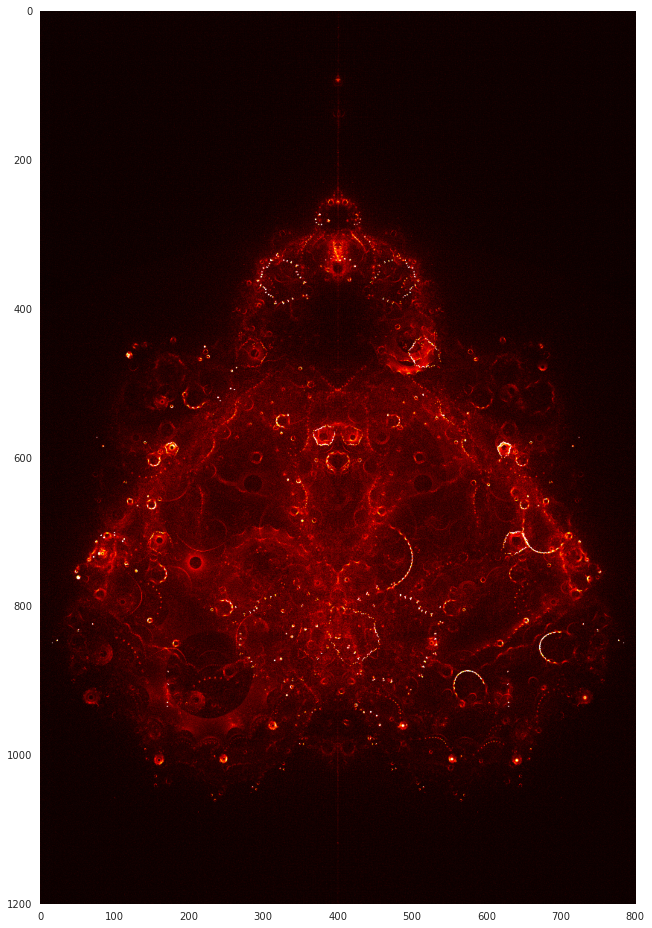

In [173]:
plt.figure(figsize = (24,16))
plt.grid(False)
plt.imshow(img.T, cmap='hot', interpolation='gaussian',vmax=np.percentile(img,99.9))

In [139]:
%%cl_kernel -o "-cl-fast-relaxed-math"

#include <pyopencl-complex.h>

typedef struct {
  int h_px;
  int w_px;
  float re_min;
  float re_max;
  float im_min;
  float im_max;
} cplane;

__kernel void qbuddhabrot(
    __global cfloat_t *phi,
    __global cplane *my_plane
)
{
    int h = (*my_plane).h_px;
    int w = (*my_plane).w_px;
    float re_min = (*my_plane).re_min;
    float re_max = (*my_plane).re_max;
    float im_min = (*my_plane).im_min;
    float im_max = (*my_plane).im_max;
    
    int gid = get_global_id(0);
    int x_i = gid % w;
    int y_i = gid / w;
    float re = re_min + ((re_max - re_min)/w)*x_i;
    float im = im_min + ((im_max - im_min)/h)*y_i;
    cfloat_t z = cfloat_new(re,im);
    cfloat_t c = z;
    int i;
    for(i=0; i<100000; i++) {
        z = cfloat_add(cfloat_mul(z,z),c);
        if(cfloat_abs(z)>4.) break;
    }
    
    z = c;
    cfloat_t z_old = c;
    float dist = 0;
    int bucket_x;
    int bucket_y;
    if(i<100000) {
        for(i=0; i<100000;i++) {
            z = cfloat_add(cfloat_mul(z,z),c);
            dist = cfloat_abs(cfloat_sub(z,z_old));
            z_old = z;
            if(cfloat_abs(z)>4.) break;
            bucket_x = int((z.real - re_min) * w / (re_max - re_min));
            bucket_y = int((z.imag - im_min) * h / (im_max - im_min));
            im = sincos(2*3.14159*float(i)/100000,&re);
            phi[bucket_y * w + bucket_x] = cfloat_add(cfloat_rmul(1.,phi[bucket_y * w + bucket_x]),cfloat_rmul(1.,cfloat_new(re,im)));
        }
    }
}

In [140]:
h_px = 400
w_px = 600

my_plane_host = np.empty(1,cplane)
my_plane_host['w_px'].fill(w_px)
my_plane_host['h_px'].fill(h_px)
my_plane_host['re_min'].fill(-2.)
my_plane_host['re_max'].fill(1.)
my_plane_host['im_min'].fill(-1.)
my_plane_host['im_max'].fill(1.)
my_plane = cl.array.to_device(queue,my_plane_host)
n = w_px*h_px
phi = cl.array.empty(queue, n, dtype=np.complex)

In [141]:
qbuddhabrot(queue, (n,), None, phi.data,my_plane.data)

In [142]:
result = phi.get()

In [93]:
result

array([  0.00000000e+00 +2.64721360e-12j,
         5.04866910e-11 +0.00000000e+00j,
         8.08873227e-14 +5.97642505e-12j, ...,
         0.00000000e+00 +0.00000000e+00j,
         0.00000000e+00 +0.00000000e+00j,   0.00000000e+00 +0.00000000e+00j])

In [94]:
%matplotlib inline

In [95]:
from seaborn import distplot

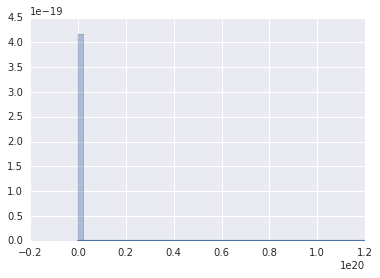

In [143]:
distplot(np.abs(result))

In [144]:
import matplotlib.pyplot as plt

In [145]:
#from https://stackoverflow.com/questions/17044052/mathplotlib-imshow-complex-2d-array
from colorsys import hls_to_rgb

def colorize(z):
    n,m = z.shape
    c = np.zeros((n,m,3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0 - 1.0/(1.0+abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a,b in zip(A,B)]
    return c

In [146]:
phi_img = np.reshape(result,[h_px,w_px])

In [153]:
type(colorize(phi_img))

numpy.ndarray

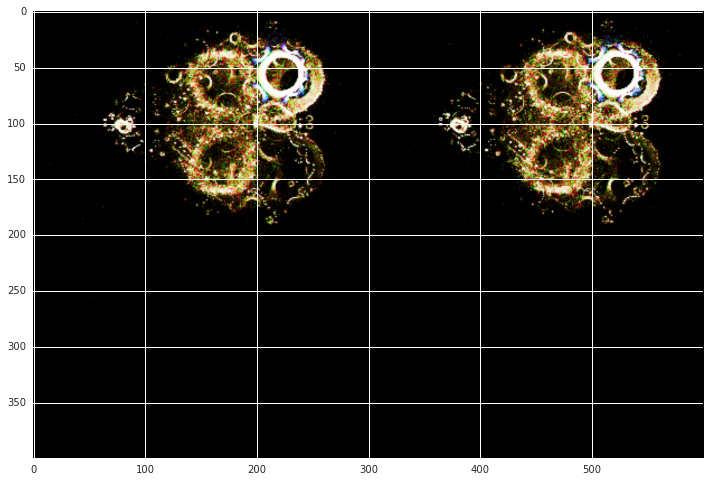

In [148]:
plt.figure(figsize = (12,8))
plt.imshow(colorize(phi_img), interpolation='gaussian')